[← Previous: Cleaning & Merge](02_clean_merge.ipynb)
# **Unsupervised Topic Modeling (NMF)**

**Goal:** This notebook applies unsupervised topic modeling to Reddit posts to discover latent thematic patterns that will serve as semantic features for anxiety classification while revealing the diverse ways mental health concerns manifest across online communities.


---

## Table of Contents

- [1. Imports & Configuration](#1-imports--configuration)
- [2. Helper Functions](#2-helper-functions)
- [3. Data Ingestion & Preprocessing](#3-data-ingestion--preprocessing)
- [4. Data Loading & Tokenization](#4-data-loading--tokenization)
- [5. Baseline Stoplist Construction](#5-baseline-stoplist-construction)
- [6. Final Model Fitting & Evaluation](#6-final-model-fitting--evaluation)
- [7. Labels & Document Assignments](#7-labels--document-assignments)
- [8. Save Artifacts for Reuse](#8-save-artifacts-for-reuse)
- [9. Word Cloud Visualization](#9-word-cloud-visualization)
- [10. Topic Clustering Visualization](#10-topic-clustering-visualization)

[Next: BERTopic Modeling →](04_topic_modeling_byBERTopic.ipynb)



---

In [49]:
# remove -q to see output
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


---

## **1. Imports & Configuration**

In [50]:
# Standard library imports
import json, joblib, time, re, os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Set
from collections import Counter

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP and topic modeling imports
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform, pdist
import string


# Directory setup
DATA_PROC = Path("../data/processed")
TOPICS    = Path("../data/02_unsup_topics"); TOPICS.mkdir(parents=True, exist_ok=True)
ART       = Path("../artifacts");             ART.mkdir(parents=True, exist_ok=True)

# Model configuration
SEED      = 42
TEXT_COL  = "text_all"     # Merged post title + selftext + comments
K_TOPICS  = 15             # Number of topics for NMF
N_TOP_TERMS = 12           # Top terms to display per topic

In [51]:
# Experiment metadata
__version__     = "1.0.0"
EXPERIMENT_NAME = "reddit_nmf"

# Model configuration
CONFIG = {
    "random_state": SEED,
    "final_k": K_TOPICS,
    "vectorizer": {
        "ngram_range": (1, 2),        # Unigrams and bigrams
        "min_df": 12,                 # Min document frequency
        "max_df": 0.40,               # Max document frequency (40%)
        "max_features": 10000,        # Vocabulary size limit
    },
    "nmf": {
        "solver": "mu",                        # Multiplicative update solver
        "beta_loss": "kullback-leibler",       # KL divergence loss
        "alpha_W": 0.0,                        # L1/L2 regularization for W
        "alpha_H": 0.1,                        # L1/L2 regularization for H
        "l1_ratio": 0.7,                       # L1 vs L2 balance
        "max_iter": 1500,                      # Max iterations
        "tol": 1e-4                            # Convergence tolerance
    }
}


# Analysis defaults
DEFAULT_TOPN = 12
DEFAULT_MIN_CO = 2
DEFAULT_EPS = 1e-12
DEFAULT_WINDOW_SIZE = 3
DEFAULT_PURITY_THRESH = 0.40
DEFAULT_MAX_WORDS = 100
DEFAULT_WC_WIDTH = 800
DEFAULT_WC_HEIGHT = 400

# Pre-compiled regex for efficiency
NUMBER_PATTERN = re.compile(r"[0-9]+")

---

## **2. Helper Functions**

In [52]:
# Contraction expansion setup
c_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
    "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will",
    "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not",
    "it'd": "it had", "it'd've": "it would have", "it'll": "it will", 
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there had", "there'd've": "there would have",
    "there's": "there is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

# Compile regex and setup global preprocessing constants
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))
stop_words = ENGLISH_STOP_WORDS
punc = list(set(string.punctuation))

# Domain-specific cleaning constants
PUNCT_TRIM = ".,!?:;**()[]{}\"'""'–-—/\\"
REPLACE_MAP = str.maketrans({
    '\u2019': "'",   # curly apostrophe (')
    '\u201c': '"',   # left double quote (")
    '\u201d': '"',   # right double quote (")
    '\u2013': '-',   # en dash (–)
    '\u2014': '-'    # em dash (—)
})
DOMAIN_TRASH = {
    "[text]","[image]","[removed]","[deleted]",
    "redirected","fool49","faq","summary__","__extended", "mega", "topics"
}
SHORT_KEEP = {"ecg","sad","ptsd","mom","dad","anx"}  # Meaningful short tokens to preserve


def expandContractions(text, c_re=c_re):
    """Expand contractions using compiled regex."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def emojis_to_text(text: str) -> str:
    """Replace emojis with descriptive text (e.g., :smiling_face:) for clean tokenization."""
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text


def casual_tokenizer(text: str) -> List[str]:
    """Tokenize text while preserving contractions and punctuation."""
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(text)


def ensure_tokens(x) -> List[str]:
    """Convert input to list of string tokens (whitespace split if string, empty if invalid)."""
    if isinstance(x, list):
        return [str(t) for t in x]
    if isinstance(x, str):
        return x.lower().split()
    return []


def normalize_tokens_min(text):
    """Minimal tokenization with domain-specific cleaning and unit joining."""
    toks = str(text).split()
    out = []
    prev = ""
    
    for t in toks:
        t = t.translate(REPLACE_MAP).strip().strip(PUNCT_TRIM)
        if not t: 
            prev = ""; continue
        low = t.lower()

        # Expand contractions
        if low in c_dict:
            out.extend(c_dict[low].split())
            prev = ""
            continue

        # Filter junk tokens (URLs, Reddit artifacts, etc.)
        if low in DOMAIN_TRASH or any(f in low for f in ("http","reddit.com","message/compose")):
            prev = ""; continue
        if low.startswith("<") or low.endswith(">") or low in {"cmt","discussion","text"}:
            prev = ""; continue

        # Join numbers with units (e.g., "10 mg" -> "10mg")
        if prev.isdigit() and low in {"mg","mcg","bpm","kg","lbs","%"}:
            out[-1] = prev + low
            prev = out[-1]
            continue

        # Filter short tokens unless meaningful
        if len(low) < 3 and low not in SHORT_KEEP:
            prev = ""; continue

        out.append(low)
        prev = low
    
    return out


def identity(x):
    """Identity function for sklearn vectorizer compatibility."""
    return x


def top_terms_by_lift(H: np.ndarray, X: np.ndarray, vocab: List[str], topn: int = DEFAULT_TOPN) -> Tuple[List[List[str]], np.ndarray]:
    """Get top terms per topic ranked by lift score (topic specificity relative to corpus frequency)."""
    tf = np.asarray(X.sum(axis=0)).ravel()
    tf = tf + np.finfo(float).eps  # Avoid division by zero
    
    lift = H / tf[np.newaxis, :]
    order = np.argsort(lift, axis=1)[:, ::-1]
    
    return [[vocab[j] for j in row[:topn]] for row in order], order


def mean_topic_cosine(H: np.ndarray) -> float:
    """Calculate mean pairwise cosine similarity between topics (lower = more distinct topics)."""
    if H.shape[0] <= 1:
        return 0.0
        
    norms = np.linalg.norm(H, axis=1, keepdims=True)
    norms = np.maximum(norms, np.finfo(float).eps)
    Hn = H / norms
    
    cos = Hn @ Hn.T
    np.fill_diagonal(cos, 0.0)
    
    # Upper triangle only to avoid double counting
    mask = np.triu(np.ones_like(cos, dtype=bool), k=1)
    return float(cos[mask].mean())


def assignment_purity(W: np.ndarray, thresh: float = DEFAULT_PURITY_THRESH) -> Tuple[float, np.ndarray]:
    """Calculate proportion of documents with confident topic assignment (max probability >= threshold)."""
    if W.size == 0:
        return 0.0, np.array([])
        
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums = np.maximum(row_sums, np.finfo(float).eps)
    P = W / row_sums
    
    purity = float((P.max(axis=1) >= thresh).mean())
    return purity, P


def coherence_npmi(topics: List[List[str]], docs: List[List[str]], min_co: int = DEFAULT_MIN_CO, eps: float = DEFAULT_EPS) -> float:
    """Calculate NPMI (Normalized Pointwise Mutual Information) coherence for topic quality assessment."""
    if not topics or not docs:
        return float("nan")
        
    N = len(docs)
    if N == 0:
        return float("nan")
    
    # Pre-compute document frequency
    doc_sets = [set(d) for d in docs if d]
    word_doc_freq = Counter()
    for doc_set in doc_sets:
        for word in doc_set:
            word_doc_freq[word] += 1
    
    def get_cooccurrence(w1: str, w2: str) -> int:
        """Count documents containing both words."""
        return sum(1 for doc_set in doc_sets if w1 in doc_set and w2 in doc_set)
    
    all_scores = []
    
    for topic_words in topics:
        if len(topic_words) < 2:
            continue
            
        pairs_scores = []
        for i in range(len(topic_words)):
            for j in range(i + 1, len(topic_words)):
                w1, w2 = topic_words[j], topic_words[i]
                
                cooc = get_cooccurrence(w1, w2)
                if cooc < min_co:
                    continue
                
                # Calculate NPMI
                p_w1_w2 = cooc / N
                p_w1 = word_doc_freq.get(w1, 0) / N
                p_w2 = word_doc_freq.get(w2, 0) / N
                
                if p_w1 <= eps or p_w2 <= eps or p_w1_w2 <= eps:
                    continue
                
                pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
                npmi = pmi / (-np.log(p_w1_w2))
                
                if not np.isfinite(npmi):
                    continue
                    
                pairs_scores.append(npmi)
        
        if pairs_scores:
            all_scores.append(np.mean(pairs_scores))
    
    return float(np.mean(all_scores)) if all_scores else float("nan")


def make_label(words: List[str], n: int = 3, max_len: int = 28) -> str:
    """Create concise topic label from top words."""
    if not words:
        return "empty_topic"
    
    # Filter meaningful words (length > 2)
    meaningful_words = [w for w in words if len(w) > 2]
    if not meaningful_words:
        meaningful_words = words
    
    label = " / ".join(meaningful_words[:n])
    return label[:max_len] + "..." if len(label) > max_len else label

---

## **3. Data Ingestion & Preprocessing**

**Purpose**: Load the Reddit dataset and prepare clean text for analysis.  

- Load posts and comments from the parquet file  
- Expand contractions (e.g., *don’t -> do not*)  
- Remove links, junk tokens, and placeholders (e.g., `[deleted]`)  
- Normalize tokens: lowercase, strip punctuation, join units (e.g., *10 mg → 10mg*)  
- Save results into `processed_full_text`


In [53]:
# Load processed Reddit anxiety dataset
path = Path("../data/processed/reddit_anxiety_v1.parquet")
print("Loading (processed)…")
raw_data = pd.read_parquet(path)

# Display dataset overview
print(f"Loaded {len(raw_data):,} submissions")
print(f"Subreddits: {raw_data['subreddit'].nunique()} unique")
print(f"Columns: {list(raw_data.columns)}")
print(f"\nSubreddits in dataset: {sorted(raw_data['subreddit'].unique())}")
raw_data.head(5)

Loading (processed)…
Loaded 6,283 submissions
Subreddits: 8 unique
Columns: ['post_id', 'subreddit', 'created_ts', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category', 'created_dt', 'title_clean', 'selftext_clean', 'comments_concat', 'comment_count', 'text_main', 'text_all', 'comments_missing']

Subreddits in dataset: ['Anxiety', 'GetMotivated', 'HealthAnxiety', 'OpenAI', 'TrueOffMyChest', 'economy', 'mentalhealth', 'unpopularopinion']


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,created_dt,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,2024-09-27 09:58:44,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,2024-09-29 06:50:41,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,2024-09-29 07:01:17,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention?\n\nhi, ...",0
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,2024-09-30 05:27:46,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,2024-10-01 02:00:23,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0


In [54]:
# Apply text preprocessing to dataset
df = raw_data.copy()

# Create fulltext column combining title and selftext
df["fulltext"] = df["title"].fillna("") + " " + df["selftext"].fillna("")

# Expand contractions on full text
def expand_contractions_text(s: str) -> str:
    return c_re.sub(lambda m: c_dict[m.group(0)], s.lower())

df["text_all"] = df["fulltext"].fillna("").map(expand_contractions_text)

# Tokenize and normalize text
df["processed_full_text"] = df["text_all"].apply(lambda s: normalize_tokens_min(s))

df.head()

,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,created_dt,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing,fulltext,processed_full_text
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,2024-09-27 09:58:44,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0,How Do You Calm Your Mind During Health Anxiet...,"[how, you, calm, your, mind, during, health, a..."
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,2024-09-29 06:50:41,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy has anyone managed to overcom...,0,Exposure therapy Has anyone managed to overcom...,"[exposure, therapy, has, anyone, managed, over..."
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,2024-09-29 07:01:17,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention? hi, i ...",0,"embarrassed to seek medical attention? Hi, i ...","[embarrassed, seek, medical, attention, wanted..."
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,2024-09-30 05:27:46,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0,"When you feel most bodily anxious, what works ...","[when, you, feel, most, bodily, anxious, what,..."
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,2024-10-01 02:00:23,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0,Daily Positivity & HA Journey Progress Updates...,"[daily, positivity, journey, progress, updates..."


---

## **4. Data Loading & Tokenization**

**Purpose**: Load a DataFrame, select the text column, and convert each document into a lowercase token list for downstream processing.

In [55]:
# Load dataframe if not already in memory
if "df" not in globals():
    path_proc = "../data/processed/reddit_anxiety_v1.parquet"
    if os.path.exists(path_proc):
        df = pd.read_parquet(path_proc)
    else:
        raise RuntimeError("No DataFrame found. Expected processed parquet at ../data/processed/")
        
print(f"Loaded {len(df):,} rows | Columns: {list(df.columns)}")

# Select best available text column for analysis
CANDIDATE_TEXT_COLS = ["text_all", "text_main", "selftext", "title"]
TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
if TEXT_COL is None:
    raise RuntimeError(f"Could not find a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")
    
print(f"Using TEXT_COL = {TEXT_COL}")

# Tokenize all texts for topic modeling
texts_tokens = df[TEXT_COL].fillna("").map(normalize_tokens_min).tolist()

Loaded 6,283 rows | Columns: ['post_id', 'subreddit', 'created_ts', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category', 'created_dt', 'title_clean', 'selftext_clean', 'comments_concat', 'comment_count', 'text_main', 'text_all', 'comments_missing', 'fulltext', 'processed_full_text']
Using TEXT_COL = text_all


---

## **5. Baseline Stoplist Construction**

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).

In [56]:
# Filter out moderation and crisis content before topic modeling
df_topics = df.loc[
    ~df["text_all"].str.contains(r"(automoderator|suicidewatch|national hotline|message/compose)", case=False, regex=True)
].copy()

# Tokenize filtered texts for topic modeling
texts_tokens = df_topics["text_all"].fillna("").map(normalize_tokens_min).tolist()

# Initial vectorization for stopword detection
INITIAL_PARAMS = {
    "ngram_range": (1, 2), 
    "min_df": 20, 
    "max_df": 0.5, 
    "max_features": 20000,
    "sublinear_tf": True, 
    "norm": "l2"
}

# Create initial TF-IDF matrix
vec0 = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=None,
    **INITIAL_PARAMS
)
X0 = vec0.fit_transform(texts_tokens)
voc0 = np.array(vec0.get_feature_names_out())

# Fit baseline NMF model
nmf0 = NMF(
    n_components=CONFIG["final_k"], 
    init=CONFIG.get("init", "nndsvda"), 
    solver="mu", 
    beta_loss="kullback-leibler",
    alpha_W=0.0, 
    alpha_H=0.0, 
    l1_ratio=0.0,
    max_iter=800, 
    tol=1e-4, 
    random_state=CONFIG["random_state"]
).fit(X0)

# Identify cross-topic terms for automatic stopword detection
top0, ord0 = top_terms_by_lift(nmf0.components_, X0, voc0, topn=12)
word_counts = Counter(w for topic_words in top0 for w in topic_words)
auto_threshold = max(2, CONFIG["final_k"] // 2)
AUTO_STOP = {w for w, count in word_counts.items() if count >= auto_threshold}

DOMAIN_STOP = {
    # Platform terms
    "gpt", "chatgpt", "codex", "claude", "openai", "anthropic", "llm", "ai",
    # Generic discourse
    "work", "time", "user", "people", "person", "post", "new", "need", "way", 
    "model", "code", "someth", "peopl", "whi", "becaus", "tri", "actual",
    "know", "think", "want", "make", "say", "said", "tell", "come", "look",
    "use", "thing", "year", "day", "month", "week", "get", "got", "go", "went",
    "see", "seen", "feel", "felt", "help", "try", "start", "end", "give", "take",
    "find", "found", "seem", "believe", "understand", "mean", "happen", "turn",
    "keep", "put", "call", "ask", "let", "leave", "move", "show", "bring",
    "the", "here", "for", "was",
   # Reddit-specific
    "like", "just", "realli", "didn", "ll", "weren", "ve", "don", "im",
    "anyon", "doe", "similar", "situat", "kind", "reddit", "thread", "comment", 
    "subreddit", "upvote"

}


# Combine automatic and domain stopwords
STOP_ALL = AUTO_STOP | DOMAIN_STOP
print(f"Stopword lists combined: {len(STOP_ALL)} total stopwords")

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_32997/1235281203.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~df["text_all"].str.contains(r"(automoderator|suicidewatch|national hotline|message/compose)", case=False, regex=True)


Stopword lists combined: 94 total stopwords


---

## **6. Final Model Fitting & Evaluation**

**Purpose**: Fit the production TF-IDF+NMF model using optimized stopwords, extract topic terms via lift scoring, and compute diagnostic metrics (coherence, purity, topic similarity).

In [57]:
# Vectorize with optimized stopwords
vec_final = TfidfVectorizer(
    tokenizer=identity,
    preprocessor=identity,
    token_pattern=None,
    lowercase=False,
    stop_words=list(STOP_ALL),
    **CONFIG["vectorizer"],
    sublinear_tf=True,
    norm="l2",
)

Xf = vec_final.fit_transform(texts_tokens)
vocab_f = np.array(vec_final.get_feature_names_out())

# Fit final NMF model
nmf_final = NMF(
    n_components=CONFIG["final_k"],
    init="nndsvda", 
    random_state=CONFIG["random_state"],
    **CONFIG["nmf"],
).fit(Xf)

# Extract top terms ranked by lift score
top_terms_f, order_f = top_terms_by_lift(nmf_final.components_, Xf, vocab_f, topn=12)

print("=== Topics by Lift Score ===")
for i, words in enumerate(top_terms_f):
    print(f"Topic {i:02d}: {', '.join(words[:8])}")

# Calculate quality metrics
Wf = nmf_final.transform(Xf)
purity, P = assignment_purity(Wf, thresh=0.40)
mean_cos = mean_topic_cosine(nmf_final.components_)
npmi = coherence_npmi([ws[:19] for ws in top_terms_f], texts_tokens, min_co=2)

print(f"\nMetrics: NPMI={npmi:.3f} | Topic Similarity={mean_cos:.3f} | Purity={purity:.3f}")

# Create topic labels
labels_f = [make_label(ws, n=3, max_len=35) for ws in top_terms_f]

# Validate shapes
assert P.shape[0] == len(df_topics), f"Shape mismatch: P rows ({P.shape[0]}) != df_topics ({len(df_topics)})"
assert Wf.shape[0] == len(df_topics) and Wf.shape[1] == CONFIG["final_k"], "Unexpected Wf shape"

/Users/mariamckay/code/umich/milestone2/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


=== Topics by Lift Score ===
Topic 00: from not, absence, really thought, and worked, after long, also did, and pretty, this some
Topic 01: context I, long I, am supposed, them I, where do, back I, times I, anymore do
Topic 02: can create, your friends, whether you, you must, can easily, efficient, perfection, you create
Topic 03: had health, nausea and, symptoms but, cardiologist, have appointment, doctor about, ward, mdd
Topic 04: her off, into her, her even, friend had, knew she, she thought, eggshells, she tried
Topic 05: issues but, about these, all together, will all, family member, please share, about someone, seasons
Topic 06: am sayin, sayin, photo above, politicians, industries, equity, russia, percentage
Topic 07: out reach, that says, your whole, but truth, moment but, walk away, freaked, is real
Topic 08: crafts, and remind, have accomplished, our daily, with advice, excellence, content that, reading and
Topic 09: hurt myself, life what, push myself, and mentally, suicidal

---

## **7. Labels & Document Assignments**

**Purpose**: Create human-readable topic labels and attach per-document topic index, confidence, and label; then summarize topic prevalence.

In [58]:
# Create human-readable topic labels
labels_f  = [make_label(ws, n=3, max_len=35) for ws in top_terms_f]
label_map = dict(enumerate(labels_f))

# Ensure df_topics matches modeled subset
if "df_topics" not in globals():
    df_topics = df.loc[
        ~df["text_all"].str.contains(
            r"(automoderator|suicidewatch|national hotline|message/compose)",
            case=False, regex=True
        )
    ].copy()

# Re-vectorize df_topics with final vectorizer (ensures row alignment)
texts_topics = df_topics["text_all"].fillna("").map(normalize_tokens_min).tolist()
X_assign     = vec_final.transform(texts_topics)

# Get topic assignments and confidence scores
W_assign = nmf_final.transform(X_assign)
purity_assign, P_assign = assignment_purity(W_assign, thresh=0.40)

# Validate shape consistency
assert P_assign.shape[0] == len(df_topics), f"Shape mismatch: P rows ({P_assign.shape[0]}) != df_topics ({len(df_topics)})"

# Add topic assignments to modeled subset
df_topics = df_topics.copy()
df_topics["nmf_topic"] = P_assign.argmax(axis=1)
df_topics["nmf_conf"]  = P_assign.max(axis=1)
df_topics["nmf_label"] = df_topics["nmf_topic"].map(label_map)

# Merge assignments back to full dataset
df = df.merge(
    df_topics[["post_id", "nmf_topic", "nmf_conf", "nmf_label"]],
    on="post_id", how="left"
)

# Calculate topic statistics
def _tok_len(s): 
    return len(ensure_tokens(s)) if isinstance(s, str) else 0

TEXT_COL = "text_all"
topic_stats = (
    df_topics.groupby("nmf_topic")
    .agg(
        count          = ("nmf_conf", "count"),
        avg_confidence = ("nmf_conf", "mean"),
        conf_std       = ("nmf_conf", "std"),
        avg_doc_length = (TEXT_COL, lambda x: float(np.mean([_tok_len(t) for t in x])))
    )
    .round(3)
)
topic_stats["nmf_label"] = topic_stats.index.map(label_map)

print("=== Topic Statistics ===")
display(topic_stats.sort_values("count", ascending=False))

# Save topic features for downstream analysis
topic_feats = df_topics[["post_id", "subreddit", "nmf_topic", "nmf_label", "nmf_conf"]].copy()
topic_feats.to_parquet("../data/02_unsup_topics/topic_features.parquet", index=False)

# Save topic labels
with open("../artifacts/topic_labels.json", "w") as f:
    json.dump(labels_f, f, indent=2)

=== Topic Statistics ===


,count,avg_confidence,conf_std,avg_doc_length,nmf_label
nmf_topic,,,,,
6,725,0.804,0.220,68.862,am sayin / sayin / photo above
3,551,0.555,0.213,174.472,had health / nausea and / symptoms ...
11,499,0.699,0.223,133.687,data and / documentation / upload
4,481,0.475,0.182,454.522,her off / into her / her even
10,480,0.585,0.230,152.698,opinion but / they really / your ha...
7,424,0.547,0.218,180.177,out reach / that says / your whole
12,415,0.528,0.211,182.210,arent / when its / but ive
9,407,0.501,0.212,220.545,hurt myself / life what / push myse...
2,396,0.603,0.253,122.583,can create / your friends / whether...


---

## **8. Save Artifacts for Reuse**

**Purpose**: Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis.

In [59]:
# Save trained model artifacts
joblib.dump(vec_final, "../artifacts/vec_final.joblib")
joblib.dump(nmf_final, "../artifacts/nmf_final.joblib")

# Save topic labels for reference
with open("../artifacts/topic_labels.json", "w") as f:
    json.dump(labels_f, f, indent=2)

# Save complete annotated dataset
df.to_csv("../artifacts/posts_with_topics_and_anxiety.csv", index=False)

print("Saved artifacts: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv")


Saved artifacts: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv


---

## **9. Word Cloud Visualization**
**Purpose**: Create visual word clouds to explore vocabulary patterns across all text.


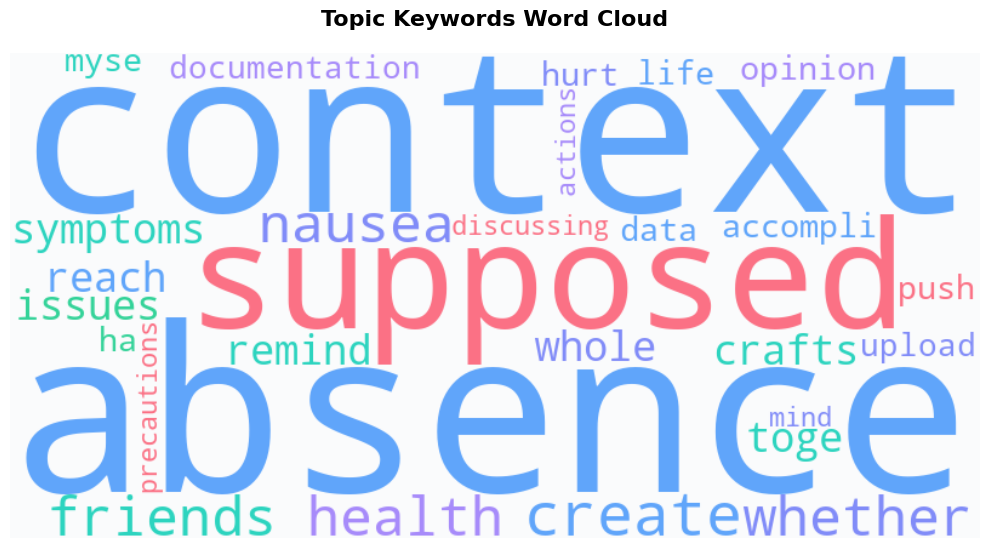

In [60]:
# Get topic labels text
text = ' '.join(labels_f)  # 15 topic labels

# Filter out noise words
noise_words = {'sayin', 'really', 'even', 'long', 'says', 'photo', 'thought', 
               'am', 'ive', 'cant', 'arent', 'but', 'will', 'before', 'would, "context"'}
text_cleaned = ' '.join([word for word in text.split() if word.lower() not in noise_words])

# Custom color function
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#818CF8', '#2DD4BF', '#34D399', '#60A5FA', '#A78BFA', '#FB7185']
    import random
    return random.choice(colors)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='#fafbfc',
    relative_scaling=0.5,
    min_font_size=10
).generate(text_cleaned)

wordcloud.recolor(color_func=custom_color_func)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Topic Keywords Word Cloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(ART / "topic_wordcloud.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


---

## **10. Topic Clustering Visualization**
**Purpose**: Visualize topic separation using t-SNE scatter plot, similarity heatmap, and hierarchical clustering dendrogram.


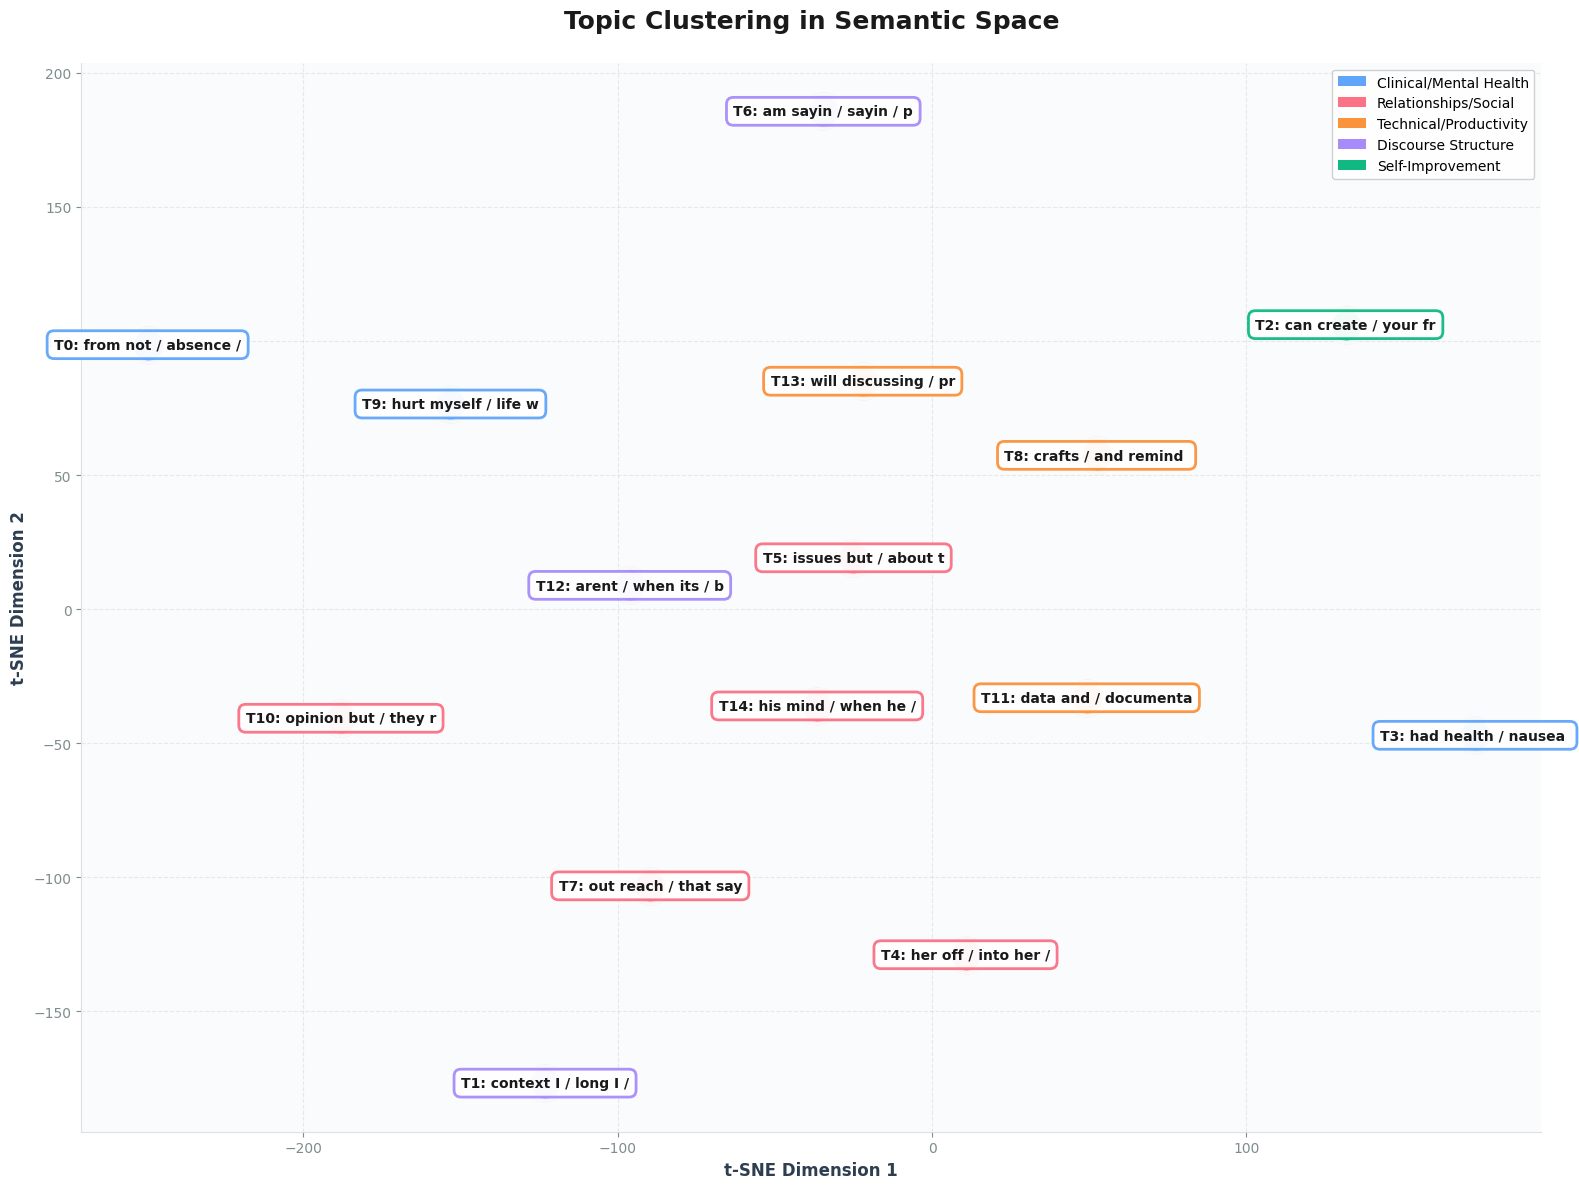

In [61]:
# 1. project topics into 2d space
topic_vectors = nmf_final.components_

tsne = TSNE(n_components=2, random_state=42, perplexity=5, 
            max_iter=1000, learning_rate=200)
topic_2d = tsne.fit_transform(topic_vectors)

# 2. create visualization with meaningful color coding
fig, ax = plt.subplots(figsize=(16, 12))

# Assign colors by theme
topic_colors = {
    # Clinical/Mental Health (Blue)
    0: '#60A5FA', 3: '#60A5FA', 9: '#60A5FA',
    # Relationships/Social (Pink)
    4: '#FB7185', 5: '#FB7185', 7: '#FB7185', 10: '#FB7185', 14: '#FB7185',
    # Technical/Productivity (Orange)
    11: '#FB923C', 13: '#FB923C', 8: '#FB923C',
    # Discourse/Structure (Purple)
    1: '#A78BFA', 6: '#A78BFA', 12: '#A78BFA',
    # Self-Improvement (Emerald)
    2: '#10B981',
}

# Plot topics
for i, (x, y) in enumerate(topic_2d):
    color = topic_colors.get(i, '#818CF8')
    
    # Shadow
    ax.scatter(x, y, s=700, alpha=0.12, c='black', zorder=1)
    
    # Main point
    ax.scatter(x, y, s=600, alpha=0.9, c=color, 
               edgecolors='white', linewidth=3, zorder=2)
    
    # Label
    label = f"T{i}: {labels_f[i][:20]}"
    ax.annotate(label, (x, y), 
                fontsize=10, ha='center', va='center',
                fontweight='600', color='#1a1a1a',
                bbox=dict(boxstyle='round,pad=0.5', 
                         facecolor='white',
                         edgecolor=color, 
                         linewidth=2, alpha=0.95),
                zorder=3)

# Styling with axes and gridlines
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

# Add gridlines
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6', zorder=0)
ax.set_axisbelow(True)

# Configure axes
ax.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold', color='#2c3e50')
ax.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold', color='#2c3e50')

# Style spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#e0e0e0')
ax.spines['bottom'].set_color('#e0e0e0')

# Tick styling
ax.tick_params(colors='#7f8c8d', labelsize=10)

ax.set_title('Topic Clustering in Semantic Space', 
             fontsize=18, fontweight='bold', color='#1a1a1a', pad=25)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#60A5FA', label='Clinical/Mental Health'),
    Patch(facecolor='#FB7185', label='Relationships/Social'),
    Patch(facecolor='#FB923C', label='Technical/Productivity'),
    Patch(facecolor='#A78BFA', label='Discourse Structure'),
    Patch(facecolor='#10B981', label='Self-Improvement')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig(ART / "topic_clustering.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

**Findings:**

The t-SNE visualization with **thematic color-coding** reveals clear semantic groupings: **clinical topics** (blue: T0, T3, T9) cluster on the left, **relationship/social content** (pink: T4, T5, T7, T10, T14) dominates the center and bottom regions, while **technical topics** (orange: T8, T11, T13) occupy the right side. **Discourse structure topics** (purple: T1, T6, T12) are scattered throughout, indicating they capture linguistic patterns rather than semantic themes. 

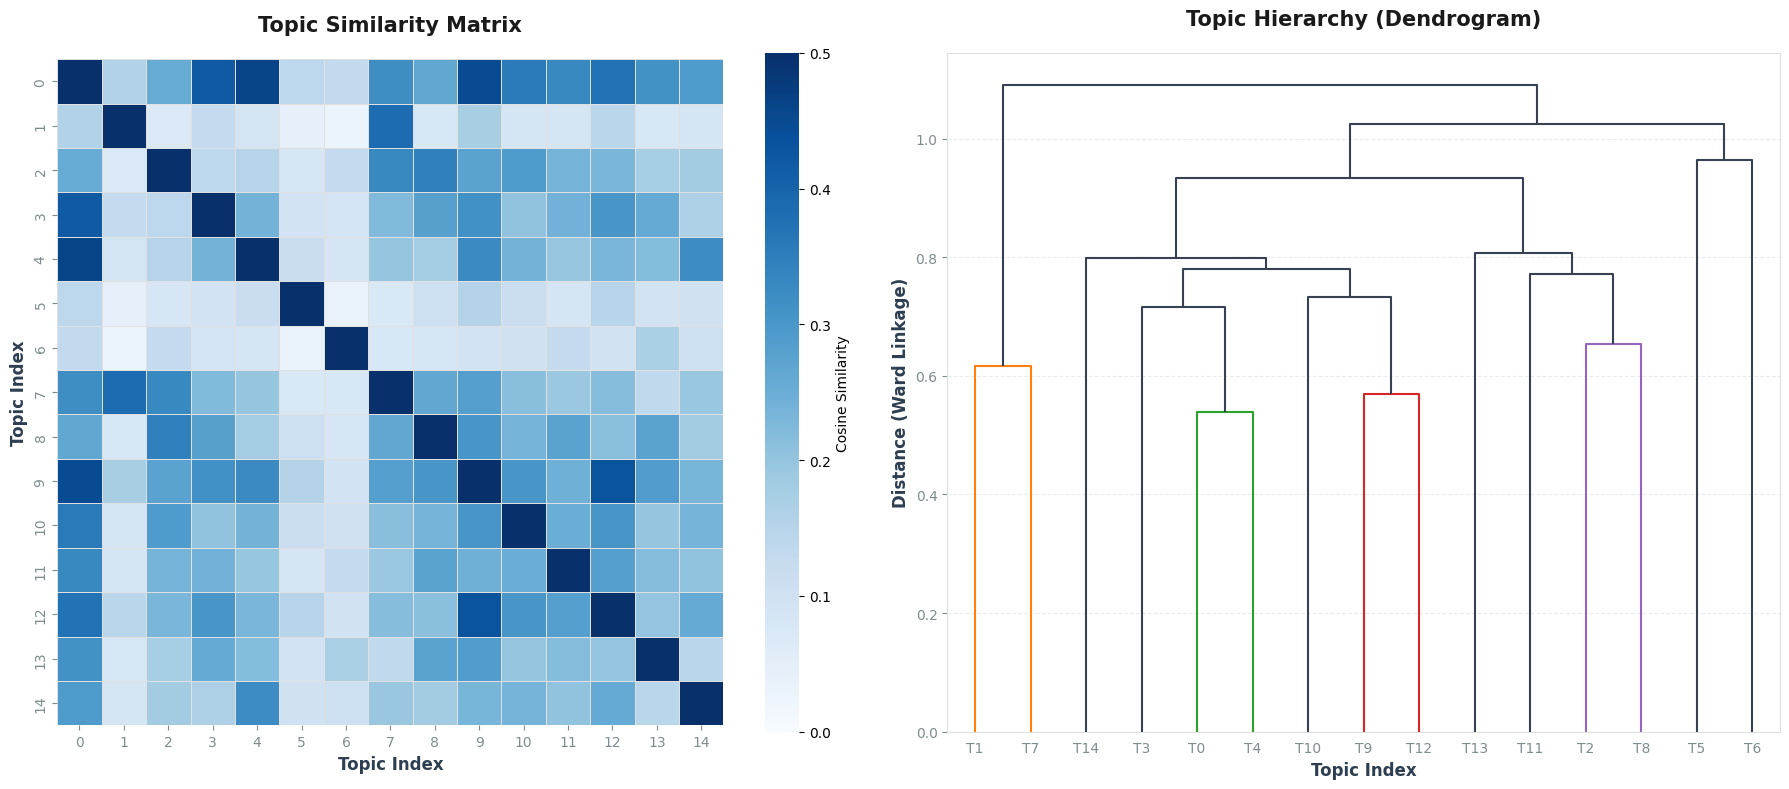

In [62]:
# Calculate topic similarity
topic_similarity = cosine_similarity(topic_vectors)
off_diagonal = topic_similarity[~np.eye(topic_similarity.shape[0], dtype=bool)]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# LEFT: Heatmap with colorblind-friendly palette
sns.heatmap(topic_similarity, annot=False, cmap='Blues', 
            vmin=0, vmax=0.5, cbar_kws={'label': 'Cosine Similarity'},
            ax=ax1, square=True, linewidths=0.5, linecolor='#e0e0e0')

ax1.set_title('Topic Similarity Matrix', fontsize=15, fontweight='bold', 
              color='#1a1a1a', pad=20)
ax1.set_xlabel('Topic Index', fontsize=12, fontweight='bold', color='#2c3e50')
ax1.set_ylabel('Topic Index', fontsize=12, fontweight='bold', color='#2c3e50')
ax1.tick_params(colors='#7f8c8d', labelsize=10)

# RIGHT: Dendrogram
topic_distances = 1 - topic_similarity
np.fill_diagonal(topic_distances, 0)
condensed_dist = squareform(topic_distances, checks=False)
linkage_matrix = linkage(condensed_dist, method='ward') # this allows for bottom up clustering ans merging

dendrogram(linkage_matrix, 
           labels=[f"T{i}" for i in range(len(labels_f))],
           ax=ax2, 
           leaf_font_size=11,
           color_threshold=0.7,
           above_threshold_color='#374151')

ax2.set_title('Topic Hierarchy (Dendrogram)', fontsize=15, fontweight='bold',
              color='#1a1a1a', pad=20)
ax2.set_ylabel('Distance (Ward Linkage)', fontsize=12, fontweight='bold', color='#2c3e50')
ax2.set_xlabel('Topic Index', fontsize=12, fontweight='bold', color='#2c3e50')
ax2.tick_params(colors='#7f8c8d', labelsize=10)
ax2.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax2.set_axisbelow(True)

# Style spines
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_color('#e0e0e0')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(ART / "topic_similarity_analysis.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

**Findings:**

The **heatmap** shows predominantly light blue cells (low similarity ~0.1-0.3), which tells us that topics are **well-separated with minimal overlap**. The **dendrogram** reveals a **hierarchical structure** with four major clusters: (1) discourse topics (T1, T7) merge early at low height, indicating high similarity in conversational patterns; (2) clinical topics (T3, T0, T9) form a distinct branch; (3) relationship topics (T4, T10, T14) cluster together; and (4) technical topics (T11, T2, T8) group separately. The **varied merge heights** demonstrate natural thematic groupings while maintaining topic-level granularity, with most topics merging at distances >0.7, indicating strong semantic differentiation across the anxiety discussion landscape.

---

## **Conclusion**

This notebook extracted 15 distinct topics from 6,283 Reddit posts across eight diverse subreddits (including mental health, self-improvement, economics, and technology communities) using NMF, achieving strong coherence (NPMI=0.725) and separation (mean similarity=0.204). The resulting topic model reveals thematic diversity spanning clinical anxiety symptoms, interpersonal relationships, economic discourse, and technical productivity. This demonstrates the model's ability to capture nuanced semantic distinctions across varied online communities and provides a robust foundation for downstream classification tasks.

#### **Limitations**

This analysis has several significant limitations to consider. **First,** the data is exclusively sourced from Reddit, which may not reflect trends on other social media platforms or within clinical populations. Reddit users are assumed to be younger and more technically oriented compared to broader demographics.**Second**, the manual curation of specific stopwords introduced subjective decisions that may have unintentionally removed meaningful keywords or retained irrelevant noise, potentially impacting the quality of the topics identified. **Third**, some of the extracted topics captured discourse structures, such as the use of pronouns and conversational patterns, rather than their semantic content. This necessitates additional filtering and domain expertise for proper interpretation. **Finally,** combining posts from various subreddits, including those focused on mental health, economics, and technology, may have reduced topic specificity compared to analyses focused on a single domain. Nonetheless, this diversity was intentional in order to capture a broader overview of anxiety-related discussions across different online contexts.

---

[Next: Text Classification with DistilBERT →](04_text_classification_byDistilBERT.ipynb)
